# Исследование продаж компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Откройте файл с данными и изучите общую информацию. 

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from scipy import stats as st

!pip install missingno
import missingno as msno

In [2]:
#вывод всех столбцов
pd.set_option('display.max_columns', None)

In [3]:
#отображение всех выводов из одной ячейки
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#сохраняем данные в переменную, разделитель запятая
games = pd.read_csv('./datasets/games.csv', sep=',')

In [5]:
#функция приведения названия колонок к нижнему регистру, заменя пробелов на "_"
def rename_col(data):
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    return data.columns

In [6]:
#вывод первых 5 строк
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
#вывод общей информации о датасете
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные состоят из 11 колонок и 16715 строк. В части колонок есть пропуски.

Колонки нужно будет изучить детальнее и, при необходимости, изменить тип данных.

Гистограммы по всем числовым колонкам датафрейма построю на шаге 2, после изменения типов данных

In [8]:
#количество пропусков в столбцах
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

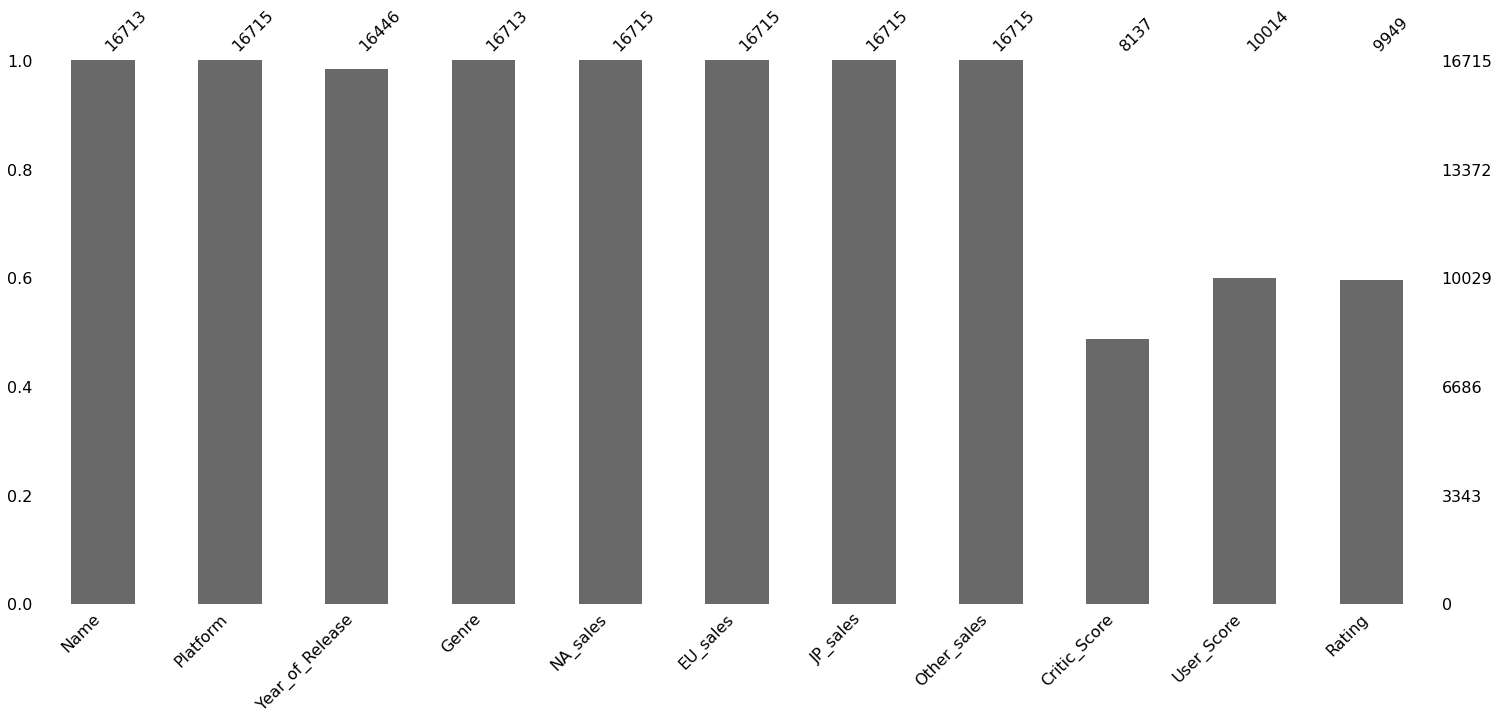

In [9]:
#визуализация пропусков
msno.bar(games);

## Подготовка данных

### Замена названий столбцов

In [10]:
#Приведем названия колонок к общему виду
rename_col(games)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типов данных

In [11]:
#посмотрим на уникальные значения колонки год
games.year_of_release.sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

Изменим тип данных на целое число, т.к тут не дата, а только год. Однако есть данные, где год не заполнен, NaN не позволит нам поменять тип. Удалим пропуски, поскольку, во-первых, таких значений совсем немного, во-вторых, определить год быстро не представляется возможным, а без года не получится корректно анализировать продажи.

In [12]:
games.dropna(subset=['year_of_release'], inplace=True)
games.year_of_release = games.year_of_release.astype(int)

In [13]:
#посмотрим на уникальные значения колонки с оценкой пользователя
games.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Встречается значение 'tbd' - To Be Determined, то есть "Будет определено". Заменю его на NaN, т.к.значение у него схожее

In [14]:
games.user_score=games.user_score.replace('tbd', np.NaN)

In [15]:
#в колонке с оценкой пользователя заменим тип на float
games.user_score = games.user_score.astype(float)

Типы в остальных колонках корректные и не требуют изменения.

Проверим типы данных после изменения.

In [16]:
games.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

### Удаление дубликатов

In [17]:
#проверка на полные дубликаты строк
games.duplicated().sum()

0

In [18]:
#уникальные значения в названии игр
games.name.sort_values().nunique()

11426

In [19]:
#приводим к нижнему регистру, заменяем пробелы на "_"
games.name=games.name.str.lower().replace(' ', '_', regex=True)

In [20]:
games.name.sort_values().nunique()

11426

Неявных дубликатов в названии не обнаружено.

Проверю на дубликаты по названию-платформе-году выпуска

In [21]:
games.duplicated(subset=['name', 'platform', 'year_of_release']).sum()
games[games.duplicated(subset=['name', 'platform', 'year_of_release'])]

2

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,madden_nfl_13,PS3,2012,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


In [22]:
#удалю эти дубликаты
games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], inplace=True)

### Визуализация всех числовых колонок

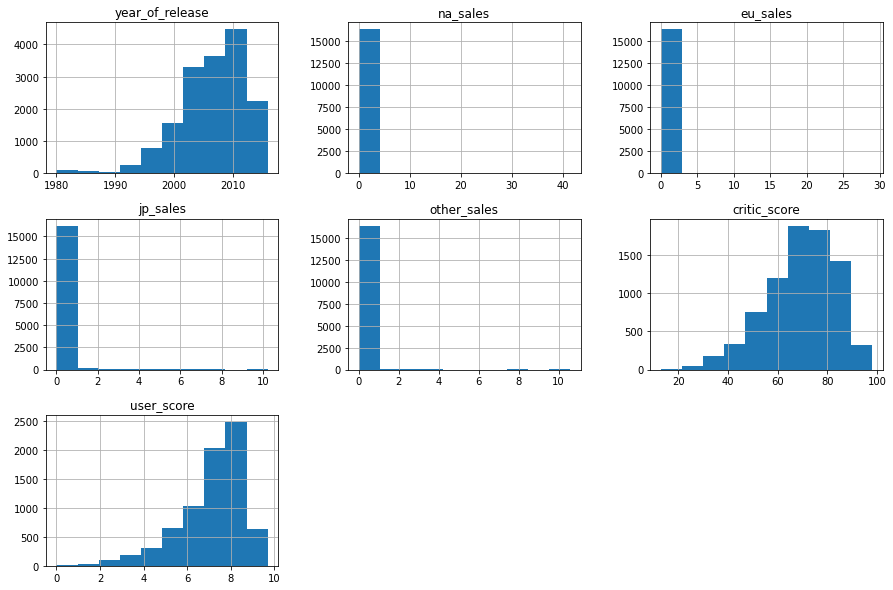

In [23]:
#гистограммы по числовым колонкам
games.hist(figsize=(15,10));

***Комментарий:***
- Графики продаж по регионам представляют собой столбцы в районе нуля, при этом масштаб оси Х говорит нам о том, что есть большие выбросы, которые нужно будет изучить подробнее.
- Оценка критиков и пользователей распределяется нормально. Большинство игр имеют оценку выше среднего (7-8 баллов у пользоватей, 70-80 у критиков).
- Игры по годам показывали рост, начиная с 1990х годов, в начале 2010х наметился спад.

### Обработка пропусков

In [24]:
games.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


В колонке с названием пропуск всего 1, причем по этой игре не известно ничего, что позволит ее идентифицировать. Удалю значение

In [25]:
games.dropna(subset=['name'], inplace = True)

Колонку год выпуска обработала выше

Посмотрю пропуски в оценке критиков, пользователей, рейтинге по годам с помощью графика

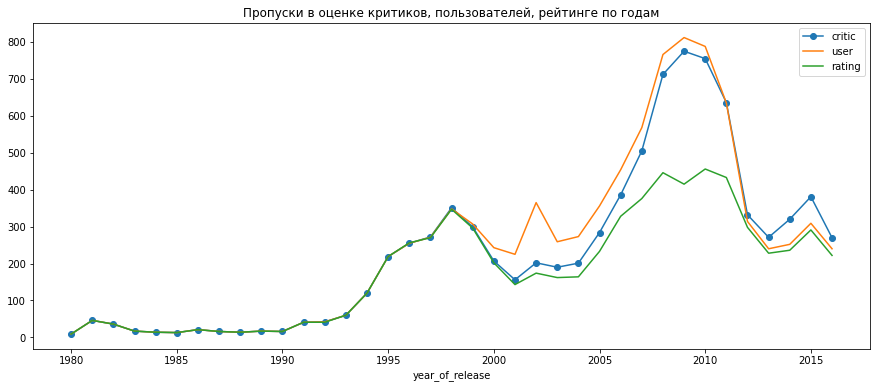

In [26]:
#график пропусков по годам
fig, ax = plt.subplots(figsize=(15,6));

critic_nan = games.query('critic_score.isna()')\
    .groupby('year_of_release') \
    .name.count()

user_nan = games.query('user_score.isna()')\
    .groupby('year_of_release') \
    .name.count()

rating_nan = games.query('rating.isna()')\
    .groupby('year_of_release') \
    .name.count()

critic_nan.plot(ax=ax,style='-o');
user_nan.plot(ax=ax);
rating_nan.plot(ax=ax);

plt.title('Пропуски в оценке критиков, пользователей, рейтинге по годам');
ax.legend(["critic", "user", "rating"]);
plt.show();

- До 1999 года количество пропусков было идентично в оценке критиков, пользователей, рейтинге по годам
- с 2020 года графики также повторяют друг друга

Возможно, дело в том, что оценки и рейтинги с каких-то платформ не отображаются или выгрузка приходит кривая.

Добавлю на график выше данные по всем играм, независимо от пропусков.

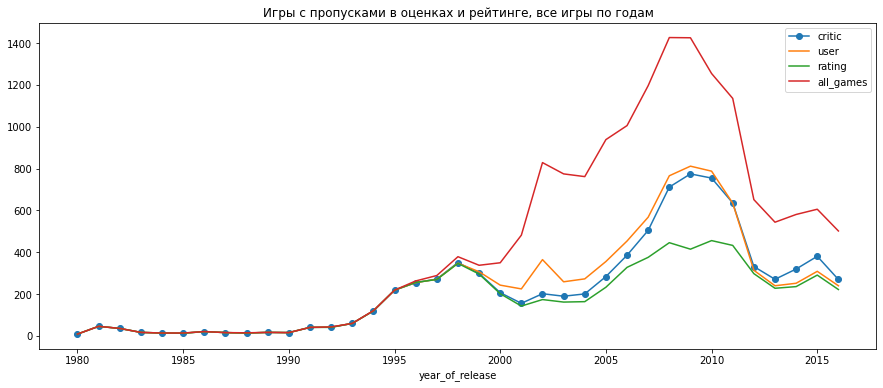

In [27]:
fig, ax = plt.subplots(figsize=(15,6));

critic_nan.plot(ax=ax,style='-o');
user_nan.plot(ax=ax);
rating_nan.plot(ax=ax);

games.groupby('year_of_release') \
    .name.count().plot(ax=ax);

plt.title('Игры с пропусками в оценках и рейтинге, все игры по годам');
ax.legend(["critic", "user", "rating", "all_games"]);
plt.show();

Получается, до 1999 года рейтинги и оценки вообще не проставлялись. Ну либо по старым данным в выгрузку не вошли. Но поскольку нас не интересует настолько старая информация, не будем выяснять причины.

Начиная с 1999 года процент незаполненных рейтингов и оценок остается стабильным, где-то половина от всех игр.

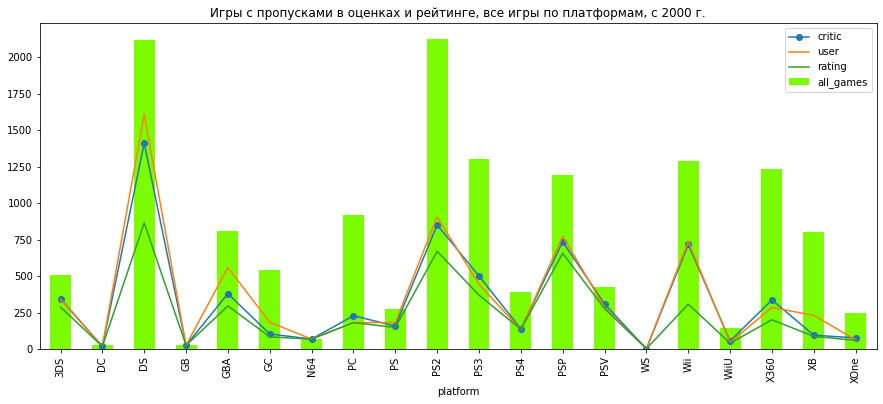

In [28]:
#график пропусков в зависимости от платформы, для данных от 2000 и свежее
fig, ax = plt.subplots(figsize=(15,6));

critic_nan1 = games.query('critic_score.isna() and year_of_release>1999')\
    .groupby('platform') \
    .name.count()

user_nan1 = games.query('user_score.isna() and year_of_release>1999')\
    .groupby('platform') \
    .name.count()

rating_nan1 = games.query('rating.isna() and year_of_release>1999')\
    .groupby('platform') \
    .name.count()

critic_nan1.plot(ax=ax,style='-o', );
user_nan1.plot(ax=ax);
rating_nan1.plot(ax=ax);

games.query('year_of_release>1999') \
    .groupby('platform') \
    .name.count() \
    .plot(ax=ax, kind='bar', color = 'lawngreen');

plt.title('Игры с пропусками в оценках и рейтинге, все игры по платформам, с 2000 г.');
ax.legend(["critic", "user", "rating", 'all_games']);
plt.show();

В разбивке по платформам соотношение сохраняется, значит пропуски - общая проблема отрасли, нужно будет уточнить у специалистов, с чем это может быть связано. Заполнять пропуски не буду, удалять тоже.

### Cуммарные продажи во всех регионах

In [29]:
#создание нового столбца
games['total_sales']=games.na_sales + games.eu_sales + games.jp_sales + games.other_sales

## Исследовательский анализ данных

### Выпуск игр по годам

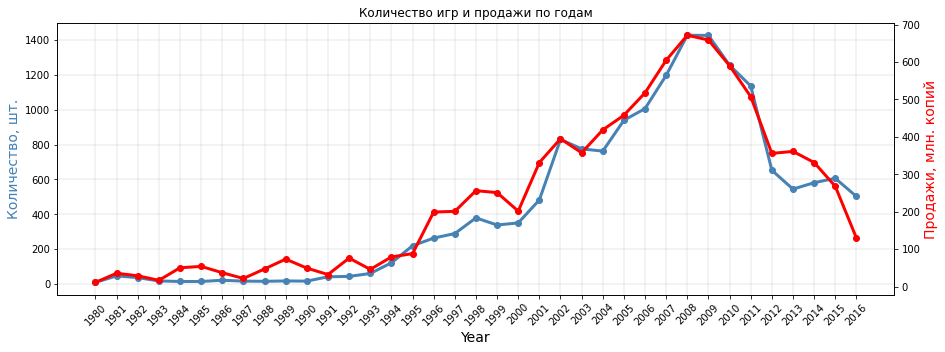

In [30]:
#группируем количество игр по годам
games_years = games.groupby('year_of_release').agg(count_games = ('name', 'count'))

#группируем продажи по годам
sales_years = games.groupby('year_of_release').agg(all_sales = ('total_sales', 'sum'))

# установка размеров графика, цветов
fig, ax = plt.subplots(figsize=(15, 5))
color1 = 'steelblue'
color2 = 'red'

#строим plot по годам: количество игр и продажи
ax.plot(games_years, color=color1, marker='o', linewidth= 3);
ax2 = ax.twinx()
ax2.plot(sales_years, color=color2, marker='o', linewidth= 3);

#добавляем x-axis label
ax.set_xlabel('Year', fontsize= 14)
#добавляем y-axis label
ax.set_ylabel('Количество, шт.', color=color1, fontsize= 14 )
ax2.set_ylabel('Продажи, млн. копий', color=color2, fontsize= 14 )

#добавляем значения по оси х и формат подписи
ax.set_xticks(games_years.index)
ax.set_xticklabels(games_years.index,rotation=45 )

#добавляем сетку и название диаграммы
ax.grid(linewidth= .3)
plt.title('Количество игр и продажи по годам');

- До 1990 игры почти не выпускались, потом начался рост. 
- Рост происходит скачкообразно, раз в несколько лет.
- С 2010 начался спад выпуска игр.
- С 2012 количество стабилизировалось.
- Продажи повторяют график количества, это значит, что игр в последние годы стали производить меньше, но и продаваться большим количеством копий они не стали, просто идет спад всей отрасли

Важны ли данные за все периоды? Я считаю, что нет. Технологии быстро развиваются и меняются, поэтому для задачи нашего исследования можно ограничиться данными за последние несколько лет. За сколько именно, определю ниже.

### Продажи по платформам

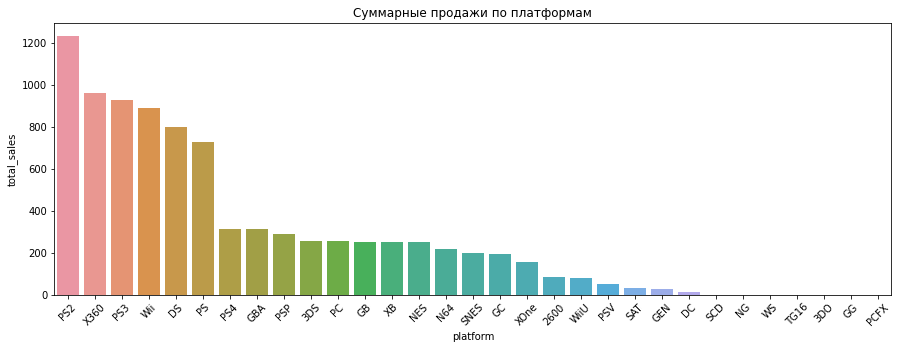

In [31]:
#группируем количество продаж по платформам
sales_platforms = games.groupby('platform') \
    .total_sales.sum() \
    .sort_values (ascending = False) \
    .reset_index()

# установка размеров графика
fig, ax = plt.subplots(figsize=(15, 5))

#строим barplot по платформам
sns.barplot(y=sales_platforms.total_sales, x=sales_platforms.platform, ax=ax);
plt.xticks(rotation=45);
plt.title('Суммарные продажи по платформам');

На графике явно выделены 6 лидеров по сумме продаж, остальные платформы отстают от них более чем в 2 раза.

Лидеры: PS, PS2, PS3, X360, Wii, DS

Отберу данные только по платформам с наибольшими суммарными продажами и построю распределение по годам. 

In [32]:
top6_list = sales_platforms.platform[0:6].tolist()
top6_platforms = games.query('platform in @top6_list')

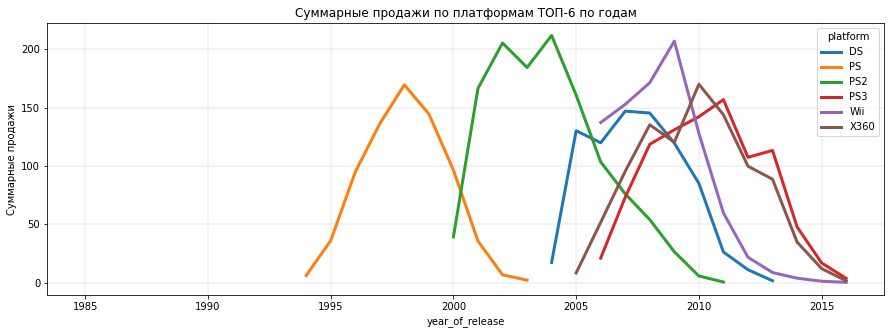

In [33]:
top6_platforms_pivot= (
    top6_platforms
    .pivot_table(index='year_of_release', columns = 'platform', values= 'total_sales',aggfunc='sum')
)

top6_platforms_pivot.plot(figsize=(15,5), linewidth=3)

plt.grid(linewidth= .3)
plt.title('Суммарные продажи по платформам ТОП-6 по годам');
plt.ylabel('Суммарные продажи');

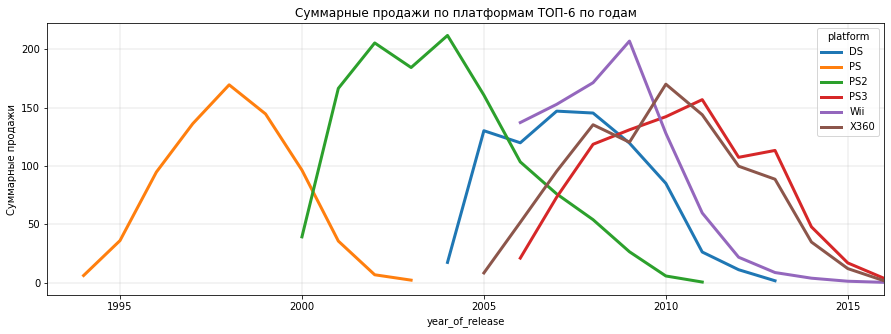

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
top6_platforms_pivot.plot(linewidth=3, ax=ax)

plt.grid(linewidth= .3)
plt.title('Суммарные продажи по платформам ТОП-6 по годам');
plt.ylabel('Суммарные продажи')
plt.xlim(1993,2016);

***Характерный срок появления новых и исчезания старых платформ составляет 5 лет. На графике явно видно, как одни лидеры сменяют других. При этом сам "срок жизни" платформ в 2 раза дольше, порядка 10 лет - это тот срок, когда платформа приносит продажи***

***Также можно заметить, что с 2005 года несколько платформ-лидеров конкурируют одновременно, они развиваются параллельно.***

***Актуальным периодом для анализа считаю последние 3 года (2014-2016), можно будет проанализировать платформы и продажи, увидеть, какие платформы прошли свой пик, и продажи будут падать, а какие только набирают популярность. Отрасль высокотехнологичная, изменяется быстро, поэтому период длиннее брать нецелесообразно.***

In [35]:
games_new = games.query('year_of_release >= 2014').reset_index(drop=True)

### Общая информация за актуальный период

In [36]:
games_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,call_of_duty:_black_ops_3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,grand_theft_auto_v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,pokemon_omega_ruby/pokemon_alpha_sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,fifa_16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,star_wars_battlefront_(2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98


In [37]:
games_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           940 non-null    object 
 11  total_sales      1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 158.5+ KB


Датасет состоит из 1689 строк, пропуски только в оценке и рейтингах

In [38]:
#Посмотрим на статистические данные по каждой колонке
games_new.describe(include = 'all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
count,1689,1689,1689.000000,1689,1689.000000,1689.000000,1689.000000,1689.000000,718.000000,888.000000,940,1689.000000
unique,956,10,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,lego_batman_3:_beyond_gotham,PS4,NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN
freq,8,376,NaN,619,NaN,NaN,NaN,NaN,NaN,NaN,271,NaN
mean,NaN,NaN,2014.953227,NaN,0.168182,0.160261,0.055115,0.048324,72.306407,6.623536,NaN,0.431883
std,NaN,NaN,0.799624,NaN,0.446134,0.466846,0.211513,0.141790,12.213500,1.589792,NaN,1.056109
min,NaN,NaN,2014.000000,NaN,0.000000,0.000000,0.000000,0.000000,19.000000,0.200000,NaN,0.010000
25%,NaN,NaN,2014.000000,NaN,0.000000,0.000000,0.000000,0.000000,66.000000,5.800000,NaN,0.030000
50%,NaN,NaN,2015.000000,NaN,0.020000,0.020000,0.010000,0.010000,74.000000,7.000000,NaN,0.100000
75%,NaN,NaN,2016.000000,NaN,0.120000,0.120000,0.040000,0.040000,81.000000,7.800000,NaN,0.350000


- Самая популярная платформа - PS4
- Популярный жанр - Action (более 35% игр)
- Количество проданных копий в основном 100 тыс., но встречаются как игры с 10 тыс, так и лидеры с 14,63 млн. копий
- Средняя оценка критиков 72 балла, у пользователей немного ниже, 6,6 балла
- А вот наиболее частая оценка схожа, 74 и 7 баллов соответственно.
- Самый популярный рейтинг «T» («Teen») — «Подросткам», хотя рейтингов всего 4 в рассматриваемый период, и представлены они все почти равномерно, что видно из данных ниже.

In [39]:
games_new.rating.value_counts()

T       271
M       265
E       219
E10+    185
Name: rating, dtype: int64

In [40]:
#заменю пропуски в рейтинге на "unknown", поскольку колонка текстовая, так можно сделать
games_new.rating.fillna('unknown', inplace=True)
games_new.rating.value_counts()

unknown    749
T          271
M          265
E          219
E10+       185
Name: rating, dtype: int64

### Анализ платформ

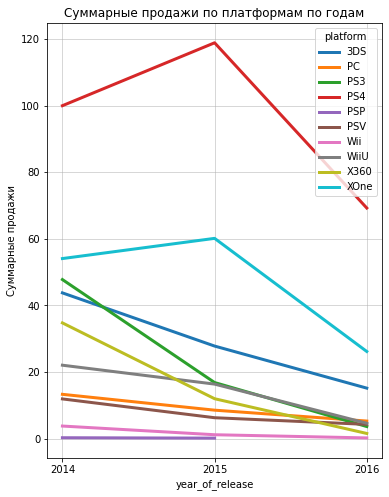

In [41]:
#сводная таблица продаж по платформам по годам
platform_pivot= (
    games_new
    .pivot_table(index='year_of_release', columns = 'platform', values= 'total_sales',aggfunc='sum')
)
platform_pivot.plot(figsize=(6,8), linewidth=3)
plt.grid(linewidth= .5)
plt.xticks(platform_pivot.index)
plt.title('Суммарные продажи по платформам по годам');
plt.ylabel('Суммарные продажи');

- Всего 10 платформ на рынке за последние 3 года
- Все платформы падают по суммарным продажам, большинство из них достигло 0, или достигнет его в 2017
- На 2015 и 2016 года лидируют по продажам XOne и PS4. Их же я считаю потенциально прибыльными на следующий период, хотя прибыль и будет уменьшаться с каждым годом

***Наблюдение:***
Я помимо данных по суммарным продажам пробовала построить график по медианным продажам. Он показал, что рост и перспективы есть у платформ Wii, WiiU, что на самом деле не соответствует действительности, т.к поддержка WiiU была прекращена в январе 2017 года, Wii еще раньше, да и всего игр, выпущенных для эти двух платформ, порядка 5% от датасета за актуальные года.

Таким образом при анализе платформ стоит обращать внимание на суммарные продажи, медиана может ввести в заблуждение. А вот при анализе жанров можно будет смотреть и на медиану.

Построю график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

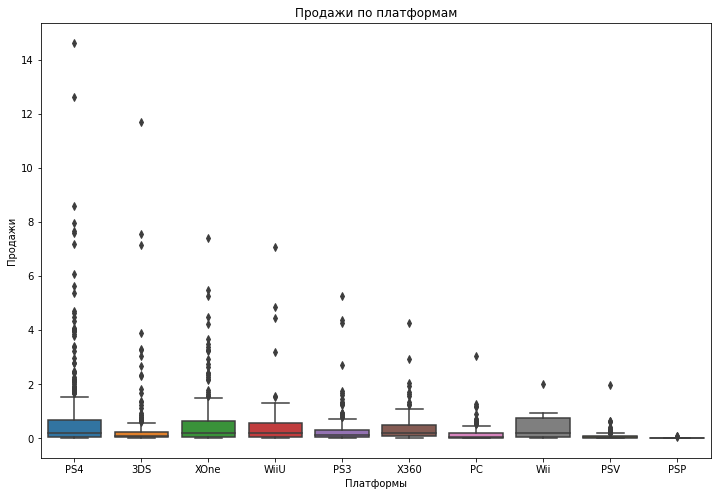

In [42]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(data=games_new, x='platform', y='total_sales');

sns.set_style('dark')
sns.set_palette('Set1');
plt.title('Продажи по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи');

Можно заметить, что почти у всех платформ существуют выбросы, причем часто довольно значительные. При этом основная масса игр на платформах продается в количестве менее 2 млн копий (граница ящика), а есть игры, которые выстреливают, их продажи превышают, например, 6 млн копий.

Посмотрим, что это за игры.

In [43]:
games_new.query('total_sales >= 6')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,call_of_duty:_black_ops_3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
1,grand_theft_auto_v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,pokemon_omega_ruby/pokemon_alpha_sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
3,fifa_16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,star_wars_battlefront_(2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
5,call_of_duty:_advanced_warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
6,fifa_17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
7,super_smash_bros._for_wii_u_and_3ds,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,unknown,7.55
8,call_of_duty:_black_ops_3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.39
9,fallout_4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


Fifa, call of duty, pokemon, fallout 4 и еще несколько игр.

Больше всего удачных игр у PS4.

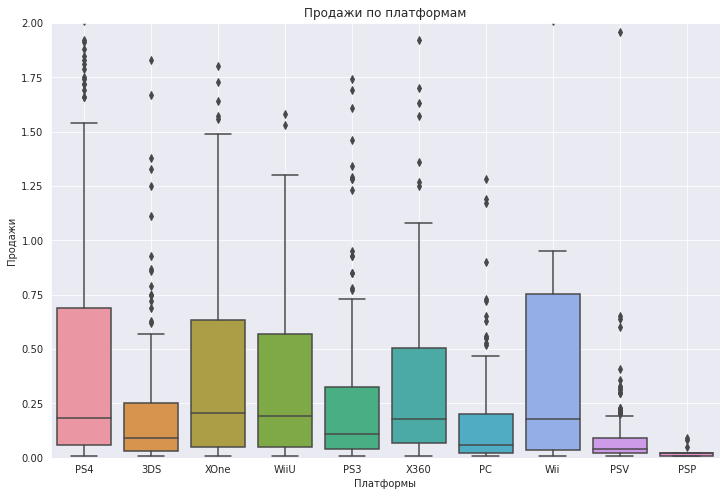

In [44]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(data=games_new, x='platform', y='total_sales');

sns.set_style('dark')
sns.set_palette('Set1');
plt.title('Продажи по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.grid()
plt.ylim(0,2);

Посмотрим крупнее ящик с усами для двух потенциально прибыльных платформ

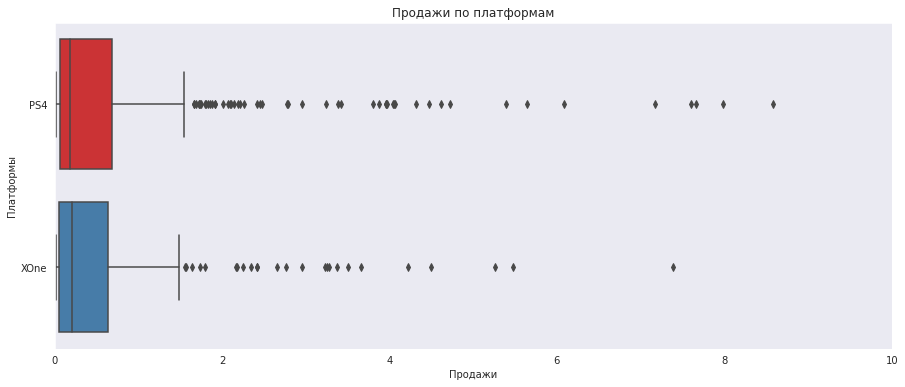

In [45]:
fig, ax = plt.subplots(figsize=(15,6))
profit_platforms = games_new.query('platform in ["XOne", "PS4"]')
sns.boxplot(data=profit_platforms, y='platform', x='total_sales');

sns.set_style('dark')
sns.set_palette('Set1');
plt.title('Продажи по платформам')
plt.ylabel('Платформы')
plt.xlabel('Продажи');
plt.xlim(0,10);

In [46]:
#сводная по двум потенциально прибыльным платформам
profit_platforms.pivot_table(index='name', columns = 'platform', values= 'total_sales',aggfunc='sum').describe()

platform,PS4,XOne
count,376.000000,228.000000
mean,0.766356,0.615614
std,1.614969,1.046513
min,0.010000,0.010000
25%,0.057500,0.050000
50%,0.185000,0.205000
75%,0.690000,0.632500
max,14.630000,7.390000


- Из графика и таблицы видно, что на PS4 выпускается больше игр в целом, 
- продаются они чуть лучше (75% продаж на уровне 690 тыс. копий против 632,5 тыс. копий на XOne)
- на PS4 удается выпускать больше игр, которые "выстреливают".

### Анализ отзывов

Посмотрю, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
Построю диаграмму рассеяния и посчитаю корреляцию между отзывами и продажами.

In [47]:
#выберем только продажи по PS4
PS4 = games_new.query('platform == "PS4"')

#посчитаем коэффициент корреляции
print('Корреляция продаж и отзывов критиков на PS4', round(PS4.total_sales.corr(PS4.critic_score)*100, 1), '%')
print('Корреляция продаж и отзывов пользователей на PS4', round(PS4.total_sales.corr(PS4.user_score)*100, 1), '%')

Корреляция продаж и отзывов критиков на PS4 40.3 %
Корреляция продаж и отзывов пользователей на PS4 -4.0 %


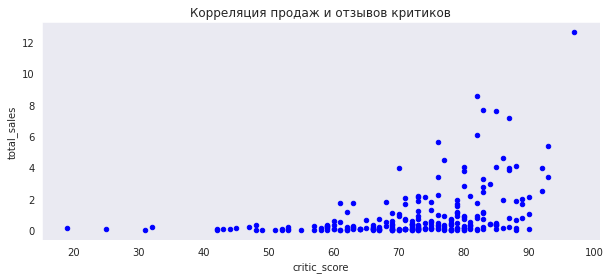

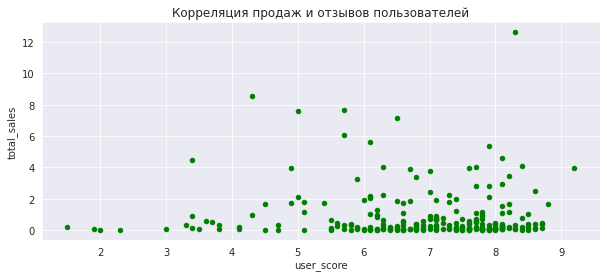

In [48]:
#построим диаграммы рассеивания продаж и отзывов критиков и пользователей по платформе PS4
PS4.plot(kind='scatter',y = 'total_sales', x = 'critic_score', figsize = (10,4), color='b');
plt.title('Корреляция продаж и отзывов критиков')

PS4.plot(kind='scatter',y = 'total_sales', x = 'user_score', figsize = (10,4), color='g');
plt.title('Корреляция продаж и отзывов пользователей')

plt.grid()
plt.show();

***Вывод:***
- Между продажами и отзывами критиков корреляция низкая, хотя и прослеживается некая связь между высокими оценками и большими продажами
- Между продажами и отзывами пользователей корреляция отсутствует вовсе

In [49]:
#посчитаем коэффициент корреляции по всем платформам сразу
print('Корреляция продаж и отзывов критиков', round(games_new.total_sales.corr(games_new.critic_score)*100, 1), '%')
print('Корреляция продаж и отзывов пользователей', round(games_new.total_sales.corr(games_new.user_score)*100, 1), '%')

Корреляция продаж и отзывов критиков 32.8 %
Корреляция продаж и отзывов пользователей -1.3 %


*Полученные корреляции подтверждают вывод выше, но уже для всех платформ*

<br>Пoсчитаю коррреляцию продаж и отзывов по еще двум популярным платформам, чтобы подтвердить вывод выше. Возьму 3DS и XOne

In [50]:
#выберем только продажи по 3DS
pl_3DS = games_new.query('platform == "3DS"')

#посчитаем коэффициент корреляции
print('Корреляция продаж и отзывов критиков на 3DS', round(pl_3DS.total_sales.corr(pl_3DS.critic_score)*100, 1), '%')
print('Корреляция продаж и отзывов пользователей на 3DS', round(pl_3DS.total_sales.corr(pl_3DS.user_score)*100, 1), '%')

Корреляция продаж и отзывов критиков на 3DS 31.4 %
Корреляция продаж и отзывов пользователей на 3DS 21.5 %


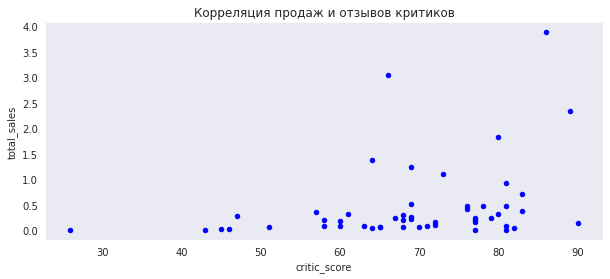

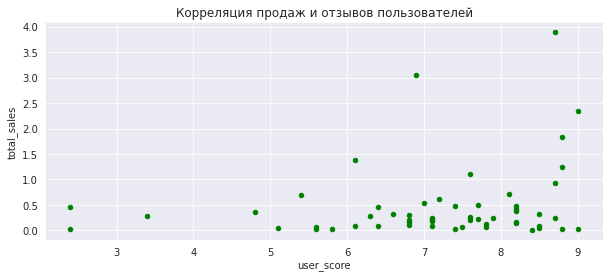

In [51]:
#построим диаграммы рассеивания продаж и отзывов критиков и пользователей по платформе 3DS
pl_3DS.plot(kind='scatter',y = 'total_sales', x = 'critic_score', figsize = (10,4), color='b');
plt.title('Корреляция продаж и отзывов критиков')

pl_3DS.plot(kind='scatter',y = 'total_sales', x = 'user_score', figsize = (10,4), color='g');
plt.title('Корреляция продаж и отзывов пользователей')

plt.grid()
plt.show();

In [52]:
#выберем только продажи по XOne
XOne = games_new.query('platform == "XOne"')

#посчитаем коэффициент корреляции
print('Корреляция продаж и отзывов критиков на XOne', round(XOne.total_sales.corr(XOne.critic_score)*100, 1), '%')
print('Корреляция продаж и отзывов пользователей на XOne', round(XOne.total_sales.corr(XOne.user_score)*100, 1), '%')

Корреляция продаж и отзывов критиков на XOne 42.9 %
Корреляция продаж и отзывов пользователей на XOne -7.0 %


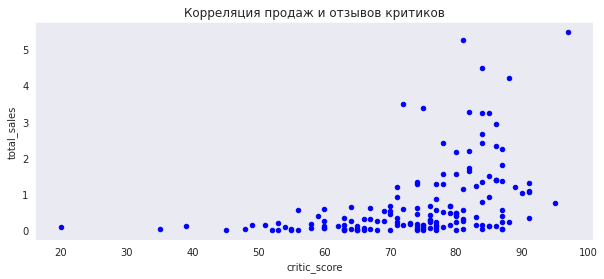

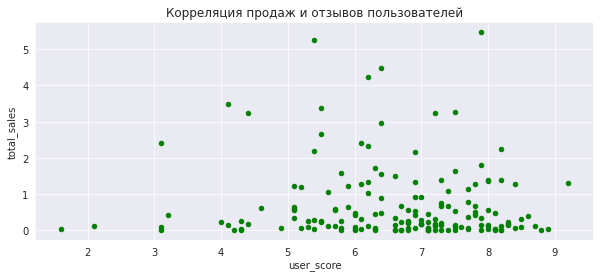

In [53]:
#построим диаграммы рассеивания продаж и отзывов критиков и пользователей по платформе XOne
XOne.plot(kind='scatter',y = 'total_sales', x = 'critic_score', figsize = (10,4), color='b');
plt.title('Корреляция продаж и отзывов критиков')

XOne.plot(kind='scatter',y = 'total_sales', x = 'user_score', figsize = (10,4), color='g');
plt.title('Корреляция продаж и отзывов пользователей')

plt.grid()
plt.show();

### Анализ жанров игр

Посмотрим на общее распределение игр по жанрам. Построим сводную таблицу продаж по жанрам. Продажи агрегируем по медиане, поскольку на суммарные продажи могут влиять выбросы в виде очень популярных игр или множества плохо продающихся, которые берут числом. Нам же нужно определить наиболее стабильные, интересные большинству жанры (т.е игры, которые покупают с большей частотностью). Но данные по суммарным продажам тоже выведу для сравнения.

In [54]:
genre_pivot = (
    games_new
    .pivot_table(index='genre', values= 'total_sales',aggfunc=['median', 'sum'])   
    .sort_values(('median', 'total_sales'), ascending=False)
)
genre_pivot.columns = ['median_sales', 'sum_sales']
genre_pivot


,median_sales,sum_sales
genre,,
Shooter,0.515,170.94
Sports,0.180,109.48
Platform,0.140,18.09
Fighting,0.125,28.22
Role-Playing,0.110,101.44
Simulation,0.100,13.13
Action,0.090,199.36
Misc,0.090,37.55
Racing,0.090,27.52


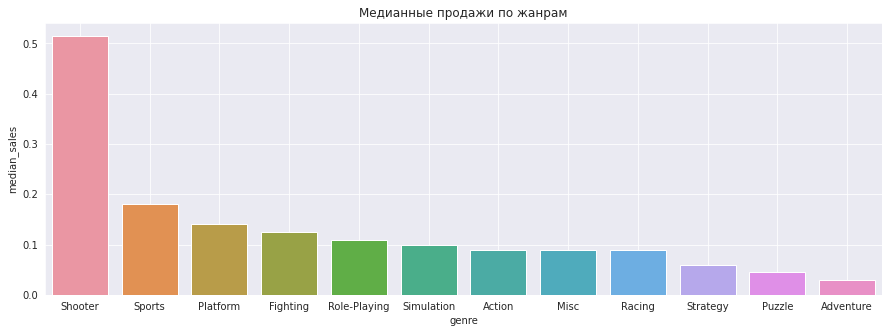

In [55]:
#строим barplot по жанрам
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_theme(style="ticks", palette="pastel")

sns.barplot(y=genre_pivot.median_sales, x=genre_pivot.index, ax=ax);

plt.grid()
plt.title('Медианные продажи по жанрам');

***Вывод:***
- На диаграмме явно выделяются жанры с высокими и низкими продажами
- Самые прибыльные жанры - Shooter, он является абсолютным лидером
- На втором месте, с разницей почти в 3 раза идет Sports, за ним Платформер
- Почти не продаются игры Puzzle, Adventure, Strategy

Посмотрю, как распределяются жанры по суммарным продажам.

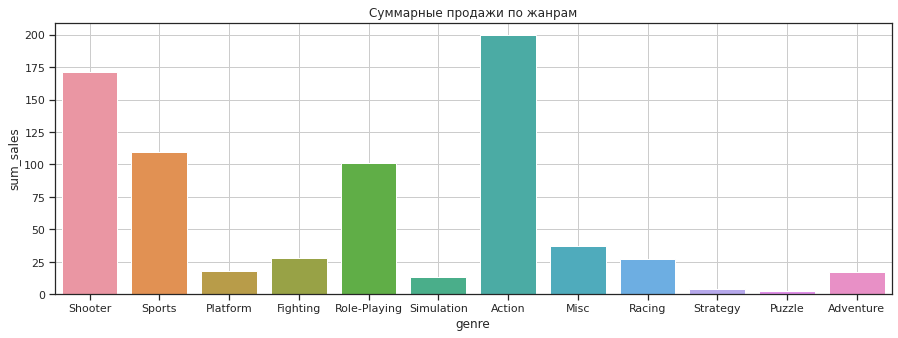

In [56]:
#строим barplot по жанрам по суммарным продажам
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_theme(style="ticks", palette="pastel")

sns.barplot(y=genre_pivot.sum_sales, x=genre_pivot.index, ax=ax);

plt.grid()
plt.title('Суммарные продажи по жанрам');

Из графика видно, что лидирует жанр Action, из чего могу сделать вывод: в этом жанре встречаются очень популярные игры, продающиеся многомиллионными тиражами. Но отмечу, что надеяться попасть на такую "жемчужину" не стоит, ставку нужно делать на более стабильные жанры.

## Портрет пользователя каждого региона (NA, EU, JP)

### Самые популярные платформы (топ-5)

In [57]:
#функция для построения круговой диаграммы по платформам по регионам
def top_platform(data):
    col=list(data.columns)
    region = {'eu_sales':'Европа', 'jp_sales' : 'Япония', 'na_sales' :'Северная Америка' }
    colors = sns.color_palette('bright')
    
    #цикл для диаграммы по каждому региону
    for c in col:
        data = data.sort_values(c, ascending=False) #сортировка по продажам текущего региона
        
        #определяем название региона на русском по словарю соответствия столбцов и рус.названий
        reg_text="".join((values for key, values in region.items() if key == c))
        
        plt.subplots(figsize=(8, 8))
        
        plt.pie(
            data[c], 
            labels=data.index, 
            colors = colors, 
            autopct = '%0.1f%%'
        );
        
        plt.title(f'Продажи игр по платформам в регионе: {reg_text}')
       
        #создаю отдельные датафреймы с топ-5 продаж по каждому региону
        globals()[('top5_'+str(c))] = data[[c]].nlargest(5, c)
              
        #вывод названия нового датафрейма
        print(f'Датафрейм ТОП-5 платформ в регионе {reg_text}', 'top5_'+str(c)) 
        
        #вывод общей доли ТОП-5 платформ в регионе
        print (f'Общая доля ТОП-5 платформ в регионе {reg_text}', round(data[c].nlargest(5).sum() / data[c].sum() *100,2))

In [58]:
#построю сводную таблицу по платформам в разрезе продаж по регионам (по сумме)
platform_region = (
    games_new
    .pivot_table(index='platform', values= ['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
)
platform_region

,eu_sales,jp_sales,na_sales
platform,,,
3DS,16.12,44.24,22.64
PC,17.97,0.00,7.23
PS3,25.54,11.22,22.05
PS4,130.04,15.02,98.61
PSP,0.00,0.36,0.00
PSV,3.53,14.54,2.52
Wii,2.59,0.00,2.08
WiiU,13.15,7.31,19.36
X360,15.49,0.08,28.30


Датафрейм ТОП-5 платформ в регионе Европа top5_eu_sales
Общая доля ТОП-5 платформ в регионе Европа 87.16
Датафрейм ТОП-5 платформ в регионе Япония top5_jp_sales
Общая доля ТОП-5 платформ в регионе Япония 99.18
Датафрейм ТОП-5 платформ в регионе Северная Америка top5_na_sales
Общая доля ТОП-5 платформ в регионе Северная Америка 89.02


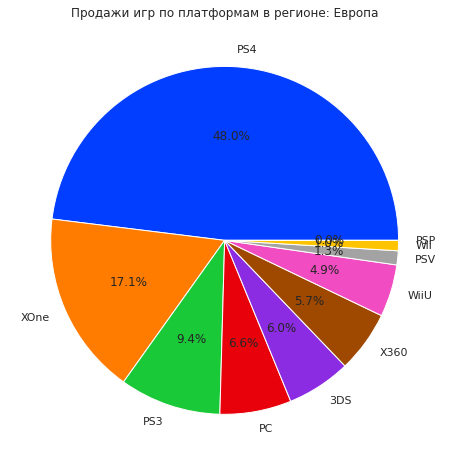

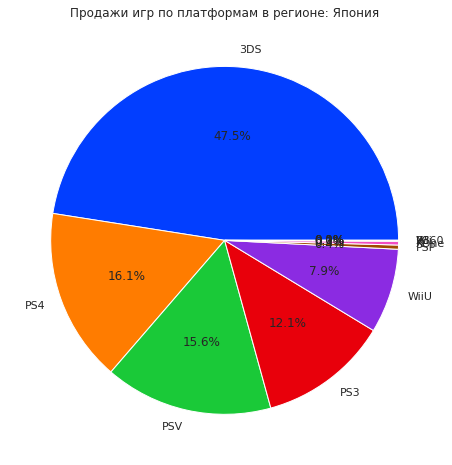

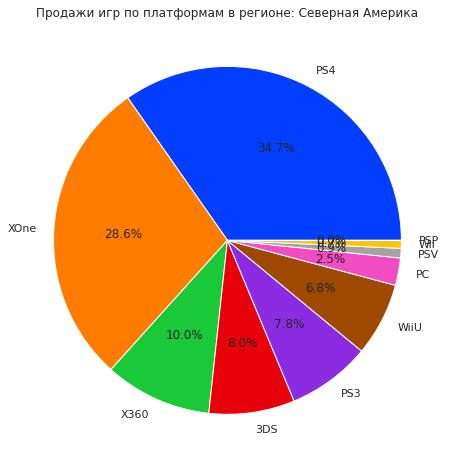

In [59]:
#вызов функции
top_platform(platform_region)

- ТОП-5 Европы составляет 87%, Северной Америки 89% от всех платформ в регионе. При этом в Японии ТОП-5 занимает более 99% рынка. Т.о рынки Европы и Америки более конкурентные. 
- в Европе PS4 (48%), XOne (17%), PS3 (9.4%), PC (6.6%), 3DS (6%)
- в Северной Америке PS4 (34,7%), XOne (28,6%), X360 (10%), 3DS (8%), PS3 (7,8%)
- в Японии 3DS (47,5%), PS4 (16,1%), PSV (15,6%), PS3 (12,1%), WiiU (7,9%)

<br>Объединю все платформы, не входящие в топ-5, в категорию "другие" и построю круговые диаграммы

In [60]:
#Функция объединение платформ за пределами топ-5 в категорию другие
def categorize_platform(row):
    try:
        if row.name<5:
            return row.platform
        else:
            return 'Other'
    except:
        pass

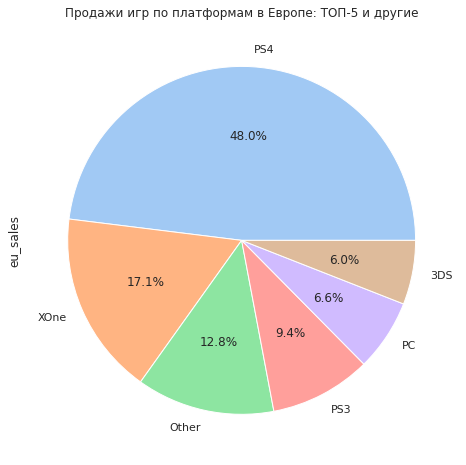

In [61]:
top_eu = platform_region[['eu_sales']].sort_values('eu_sales', ascending=False).reset_index()
top_eu['platform_group']= top_eu.apply(categorize_platform, axis=1)

(top_eu.groupby('platform_group')
    .eu_sales.sum()
    .sort_values(ascending=False).
    plot(kind='pie', autopct = '%0.1f%%', figsize=(8,8))
)
plt.title('Продажи игр по платформам в Европе: ТОП-5 и другие');

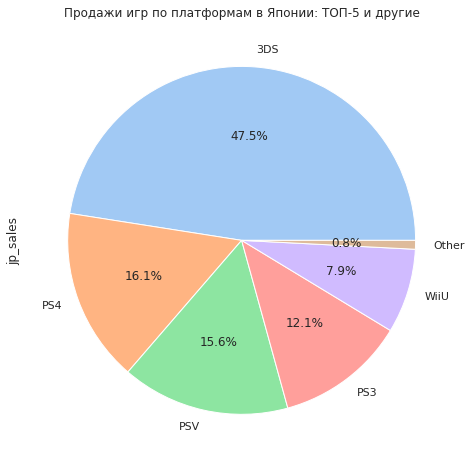

In [62]:
top_jp = platform_region[['jp_sales']].sort_values('jp_sales', ascending=False).reset_index()
top_jp['platform_group']= top_jp.apply(categorize_platform, axis=1)

(top_jp.groupby('platform_group')
    .jp_sales.sum()
    .sort_values(ascending=False).
    plot(kind='pie', autopct = '%0.1f%%', figsize=(8,8))
)
plt.title('Продажи игр по платформам в Японии: ТОП-5 и другие');

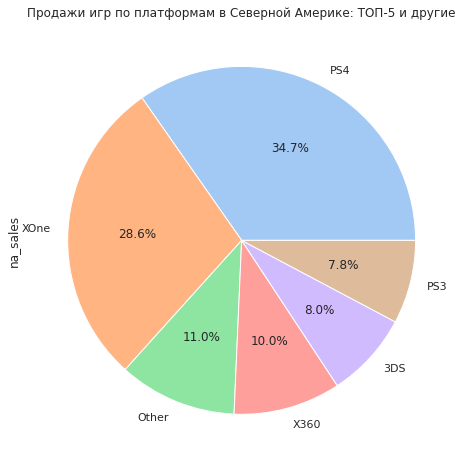

In [63]:
top_na = platform_region[['na_sales']].sort_values('na_sales', ascending=False).reset_index()
top_na['platform_group']= top_na.apply(categorize_platform, axis=1)

(top_na.groupby('platform_group')
    .na_sales.sum()
    .sort_values(ascending=False).
    plot(kind='pie', autopct = '%0.1f%%', figsize=(8,8))
)
plt.title('Продажи игр по платформам в Северной Америке: ТОП-5 и другие');

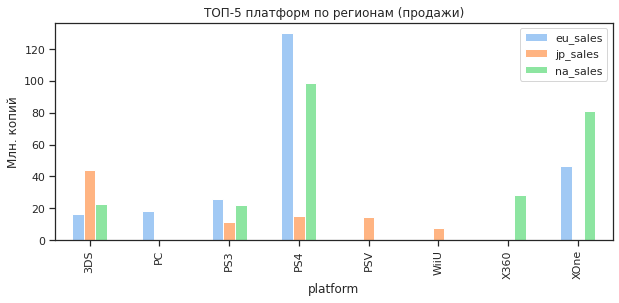

In [64]:
#соединяем в общий датафрейм данные по ТОП-5 по регионам
top5_platform = top5_eu_sales.merge(top5_jp_sales, how='outer', left_index=True, right_index=True)
top5_platform = top5_platform.merge(top5_na_sales, how='outer', left_index=True, right_index=True)
top5_platform.plot(kind='bar', figsize = (10,4))
plt.ylabel('Млн. копий');
plt.title('ТОП-5 платформ по регионам (продажи)');

- ТОП-5 платформ в Европе и Северной Америке почти одинаковый (PS4, XOne, PS3, 3DS), совпадают 4 платформы из 5, только отличаются доли продаж.
-  Рынок Японии сильно отличается, основная платформа на нем 3DS - портативная игровая система производства Nintendo. Я думаю, это связано с тем, что японцы часто играют вне дома.

### Самые популярные жанры (топ-5)

In [65]:
#функция для построения bar диаграммы по жанрам по регионам
def top_genre(data):
    col=list(data.columns)
    region = {'eu_sales':'Европа', 'jp_sales' : 'Япония', 'na_sales' :'Северная Америка' }
    colors = sns.color_palette('bright')
    
    #цикл для диаграммы по каждому региону
    for c in col:
        data = data.sort_values(c, ascending=False) #сортировка по медиане текущего региона
        
        #определяем название региона на русском по словарю соответствия столбцов и рус.названий
        reg_text="".join((values for key, values in region.items() if key == c))
        
        plt.subplots(figsize=(15, 4))
        
        sns.barplot(
            y=data[c], 
            x=data.index,             
        );
        plt.ylabel('Медианные продажи')
        plt.title(f'Медианные продажи игр по жанрам в регионе: {reg_text}')
       
        #создаю отдельные датафреймы с топ-5 продаж по каждому региону
        globals()[('top5genre_'+str(c))] = data[[c]].nlargest(5, c)
              
        #вывод названия нового датафрейма
        print(f'Датафрейм ТОП-5 жанров в регионе {reg_text}', 'top5genre_'+str(c)) 
        

In [66]:
#построю сводную таблицу по жанрам в разрезе продаж по регионам (по медиане)
genre_region = (
    games_new
    .pivot_table(index='genre', values= ['na_sales', 'eu_sales', 'jp_sales'], aggfunc='median')
)
genre_region

,eu_sales,jp_sales,na_sales
genre,,,
Action,0.020,0.01,0.010
Adventure,0.000,0.01,0.000
Fighting,0.020,0.03,0.040
Misc,0.010,0.01,0.010
Platform,0.055,0.00,0.075
Puzzle,0.000,0.03,0.000
Racing,0.050,0.00,0.030
Role-Playing,0.010,0.05,0.020
Shooter,0.220,0.00,0.220


Датафрейм ТОП-5 жанров в регионе Европа top5genre_eu_sales
Датафрейм ТОП-5 жанров в регионе Япония top5genre_jp_sales
Датафрейм ТОП-5 жанров в регионе Северная Америка top5genre_na_sales


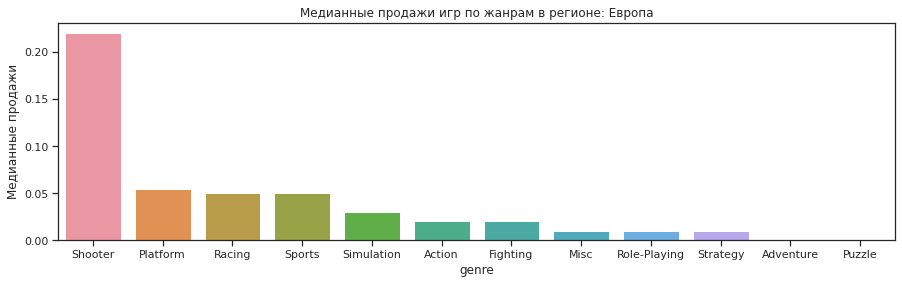

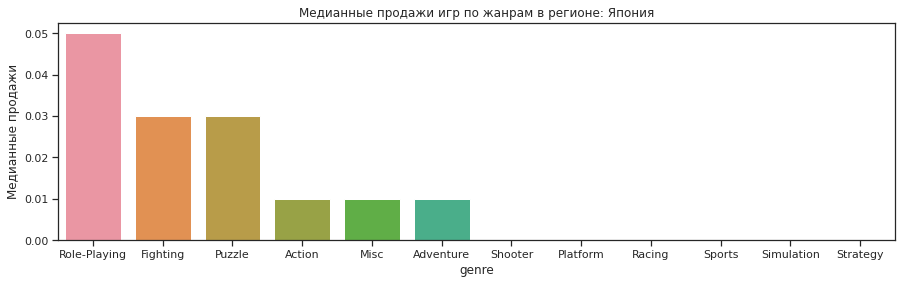

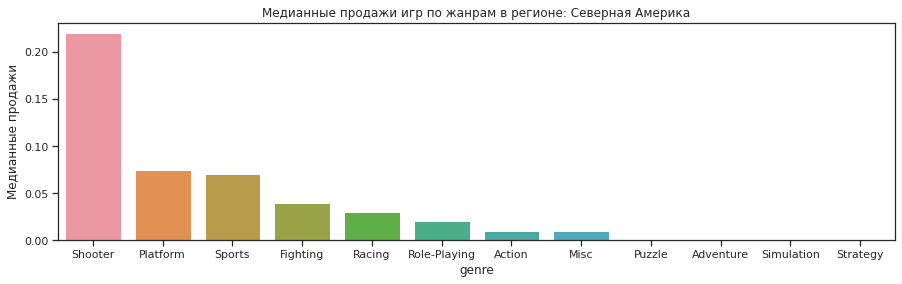

In [67]:
top_genre(genre_region)

In [68]:
#соединяем в общий датафрейм данные по ТОП-5 по регионам
top5_genre = top5genre_eu_sales.merge(top5genre_jp_sales, how='outer', left_index=True, right_index=True)
top5_genre = top5_genre.merge(top5genre_na_sales, how='outer', left_index=True, right_index=True)

top5_genre

,eu_sales,jp_sales,na_sales
genre,,,
Action,NaN,0.01,NaN
Fighting,NaN,0.03,0.040
Misc,NaN,0.01,NaN
Platform,0.055,NaN,0.075
Puzzle,NaN,0.03,NaN
Racing,0.050,NaN,0.030
Role-Playing,NaN,0.05,NaN
Shooter,0.220,NaN,0.220
Simulation,0.030,NaN,NaN


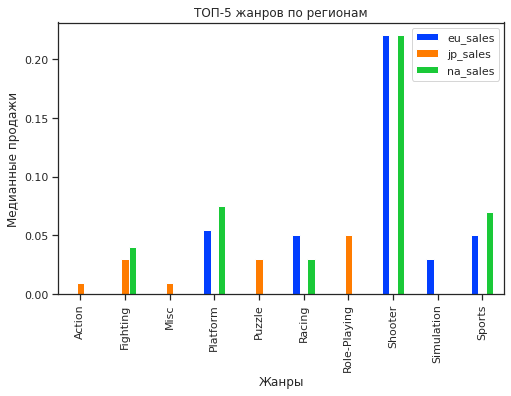

In [69]:
color_bar=sns.color_palette('bright')
top5_genre.plot(kind='bar', figsize = (8,5), color=color_bar)
plt.title('ТОП-5 жанров по регионам')
plt.ylabel('Медианные продажи')
plt.xlabel('Жанры');

***Картина по жанрам повторяет ситуацию с платформами, рынки Европы и Северной Америки похожи, Япония от них сильно отличается***
- В Европе и Америке с большим отрывом лидируют шутеры, затем идут платформеры и спортивные игры, на 4 месте гонки.
- 5 место отличается: в Европе это симуляторы, в Америке файтинг.
- В Японии в топе Role-Playing, файтинг и пазлы.
- Можно заметить, что основное колличество игр продается тиражом менее 100 тыс. копий, а в Японии менее 50 тыс. копий. Т.о. для успешности бизнеса необходимо реализовывать большое количество игр

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [70]:
#построю сводную таблицу по рейтингу в разрезе продаж по регионам (по медиане)
rating_region = (
    games_new
    .pivot_table(index='rating', values= ['na_sales', 'eu_sales', 'jp_sales'], aggfunc='median')
)
rating_region

,eu_sales,jp_sales,na_sales
rating,,,
E,0.05,0.00,0.05
E10+,0.09,0.00,0.10
M,0.12,0.00,0.12
T,0.04,0.01,0.03
unknown,0.00,0.02,0.00


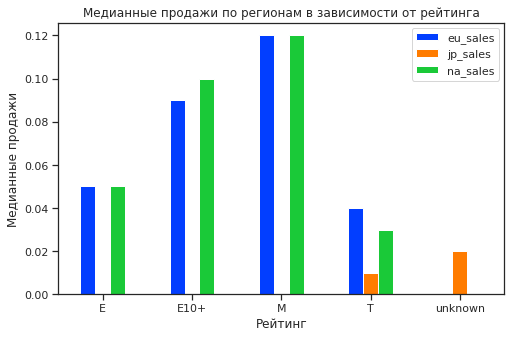

In [71]:
rating_region.plot(kind='bar', figsize = (8,5), color=color_bar)
plt.title('Медианные продажи по регионам в зависимости от рейтинга')
plt.ylabel('Медианные продажи')
plt.xticks(rotation=0);
plt.xlabel('Рейтинг');

- Рейтинг ESRB не оказывает влияния на продажу игр в Японии. Я считаю, это связано с тем, что система рейтинга ESRB - американская, в Японии есть своя система CERO, на которую и ориентируется местный рынок.

В Америке и Европе ESRB влияет на продажи, одинаково для обоих регионов
- больше всего продается игр «M» («Mature») — «Для взрослых» (от 17 лет).
- На втором месте E10+, для всех от 10 лет, 
- на третьем E - для всех (6+ лет), - 
-на четвертом игры для подростков (13+ лет)

## Проверка гипотез

Проверим две гипотезы
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза всегда формулируется через равенство значений, альтернативная гипотеза - гипотеза, которая противоречит нулевой (может быть двусторонней или односторонней, в зависимости от задач исследования).

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые ###

H_0: Средний пользовательский рейтинг платформы Xbox One = Средний пользовательский рейтинг платформы PC

H_a: Средний пользовательский рейтинг платформы Xbox One ≠ Средний пользовательский рейтинг платформы PC

alpha = 0.05

In [72]:
#данные для проверки гипотезы
rating_xone = games_new.query('platform == "XOne" and user_score.notna()').user_score
rating_pc = games_new.query('platform == "PC" and user_score.notna()').user_score

print ('Количество наблюдений пользовательского рейтинга платформы')
print ('Xbox One =', len(rating_xone))
print ('PC =', len(rating_pc))
print('-'*40)
print ('Средний пользовательский рейтинг платформы')
print ('Xbox One =', round(rating_xone.mean(),2))
print ('PC =', round(rating_pc.mean(),2))

Количество наблюдений пользовательского рейтинга платформы
Xbox One = 165
PC = 122
----------------------------------------
Средний пользовательский рейтинг платформы
Xbox One = 6.59
PC = 6.3


In [73]:
#вызов метода для проверки гипотезы
results = st.ttest_ind(rating_xone,rating_pc, equal_var=False)

# alpha = значение уровня значимости
alpha=0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


- уровень значимости определила как 5%, поскольку наблюдений не так много, меньше 1000, поэтому делать тест более чувствительным не стоит
- критерий для проверки гипотез применила t-test Стюдента для сравнения средних значений двух групп, поскольку данные независимы и распределены нормально.
- при проверке гипотезы не обнаружила статистически значимых различий между пользовательскими оченками двух платформ, соответственно, нулевую гипотезу не отвергаю. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

### Средние пользовательские рейтинги жанров Action и Sports разные. ###

H_0: Средний пользовательский рейтинг жанра Action = Средний пользовательский рейтинг жанра Sports

H_a: Средний пользовательский рейтинг жанра Action ≠ Средний пользовательский рейтинг жанра Sports

alpha = 0.05

In [74]:
#данные для проверки гипотезы
rating_action = games_new.query('genre == "Action" and user_score.notna()').user_score
rating_sports = games_new.query('genre == "Sports" and user_score.notna()').user_score

print ('Количество наблюдений пользовательского рейтинга жанра')
print ('Action =', len(rating_action))
print ('Sports =', len(rating_sports))
print('-'*40)
print ('Средний пользовательский рейтинг жанра')
print ('Action =', round(rating_action.mean(),2))
print ('Sports =', round(rating_sports.mean(),2))

Количество наблюдений пользовательского рейтинга жанра
Action = 297
Sports = 127
----------------------------------------
Средний пользовательский рейтинг жанра
Action = 6.76
Sports = 5.23


In [75]:
#вызов метода для проверки гипотезы
results = st.ttest_ind(rating_action,rating_sports, equal_var=False)

# alpha = значение уровня значимости
alpha=0.05

# вывод значения p-value на экран 
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.1825550382644557e-14
Отвергаем нулевую гипотезу


- уровень значимости определила как 5%, поскольку наблюдений не так много, меньше 1000, поэтому делать тест более чувствительным не стоит
- критерий для проверки гипотез применила t-test Стюдента для сравнения средних значений двух групп, поскольку данные независимы и распределены нормально.
- при проверке гипотезы обнаружила статистически значимые различя между пользовательскими оченками двух платформ, соответственно, нулевую гипотезу отвергаю. Средние пользовательские рейтинги жанров Action и Sports разные

## Общий вывод

На рынке представлено большое количество различных игр. Они отличаются как по платформам, так и по жанрам.

***В целом по отрасли:***
- С 2012 года наблюдается спад игровой отрасли, игр в последние годы стали производить меньше, но и продаваться большим количеством копий они не стали.
- Самая популярная платформа - PS4
- Популярный жанр - Action (более 35% игр). В этом жанре встречаются очень популярные игры, продающиеся многомиллионными тиражами. Но отмечу, что надеяться попасть на такую "жемчужину" не стоит, ставку нужно делать на более стабильные жанры.
- Количество проданных копий в основном 100 тыс., но встречаются как игры с 10 тыс, так и лидеры с 14,63 млн. копий
- Средняя оценка критиков 72 балла, у пользователей немного ниже, 6,6 балла. А вот наиболее частая оценка схожа, 74 и 7 баллов соответственно.
- Рейтингов всего 4 в рассматриваемый период, и представлены они все почти равномерно. При этом почти в половине игр рейтинг не определен.
- Всего 10 платформ на рынке представлены за последние 3 года
- Характерный срок появления новых и исчезания старых платформ составляет 5 лет
- На 2015 и 2016 года лидируют по продажам XOne и PS4. Их же я считаю потенциально прибыльными на следующий период, хотя прибыль и будет уменьшаться с каждым годом
- Между продажами и отзывами критиков корреляция низкая
- Между продажами и отзывами пользователей взаимосвязь отсутствует вовсе

***Платформы***
- ТОП-5 Европы составляет 87%, Северной Америки 89% от всех платформ в регионе. При этом в Японии ТОП-5 занимает более 99% рынка. Т.о рынки Европы и Америки более конкурентные. 
- ТОП-5 платформ в Европе и Северной Америке почти одинаковый (PS4, XOne, PS3, 3DS), совпадают 4 платформы из 5, только отличаются доли продаж.
-  Рынок Японии сильно отличается, основная платформа на нем 3DS - портативная игровая система производства Nintendo. Это связано с тем, что японцы часто играют вне дома.

***Картина по жанрам повторяет ситуацию с платформами, рынки Европы и Северной Америки похожи, Япония от них сильно отличается***
- В Европе и Америке с большим отрывом лидируют шутеры, затем идут платформеры и спортивные игры, на 4 месте гонки.
- 5 место отличается: в Европе это симуляторы, в Америке файтинг.
- В Японии в топе Role-Playing, файтинг и пазлы.
- Можно заметить, что основное колличество игр продается тиражом менее 100 тыс. копий, а в Японии менее 50 тыс. копий. Т.о. для успешности бизнеса необходимо реализовывать большое количество игр

***Рейтинг ESRB***
- Рейтинг ESRB не оказывает влияния на продажу игр в Японии, поскольку там своя система CERO, на которую и ориентируется местный рынок.
- В Америке и Европе ESRB влияет на продажи, одинаково для обоих регионов, больше всего продается игр «M» — «Для взрослых» (от 17 лет), на втором месте E10+ (для всех от 10 лет).

***Рекомендации по планированию рекламных кампаний и определению успешных тенденций:***
- Игроки в разных регионах имеют собственные предпочтения, которые могут выделять их на фоне остального мира. На Западе и Востоке пользователи предпочитают разные платформы и жанры, поэтому важно учитывать эти отличия для успешного международного релиза.
- Ставку стоит сделать на платформы XOne и PS4 для Запада и на 3DS для Японии
- На игры категорий M и E10+
- Жанры для Запада: шутеры, платформеры и спортивные игры
- Жанры для рынка Японии: Role-Playing, файтинг и пазлы